In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [3]:
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [4]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

# cat_vars = ['DayOfWeek', 'Day']


In [5]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']
# contin_vars = []

In [6]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [7]:
uniques

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Promo2SinceYear,State,Week,Events,Promo_fw,Promo_bw,StateHoliday_bool_fw,StateHoliday_bool_bw,SchoolHoliday_fw,SchoolHoliday_bw
uniques,1115,7,3,12,31,4,25,26,4,3,...,8,12,52,22,6,6,3,3,8,8


# Asignación de dimensión de embeddings

In [8]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [9]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 2 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 10 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 3 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 1 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 2 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 2 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 

# Definición de modelo

In [10]:
add_customers = True
log_output = False
output_activation = 'linear'

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [13]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [14]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [15]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs

In [16]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [17]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [18]:
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [19]:
model.save_weights('initial_weights.hdf5')

In [20]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


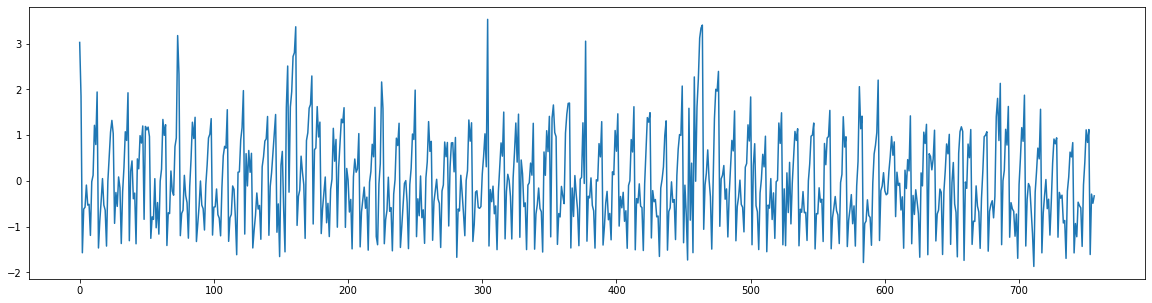

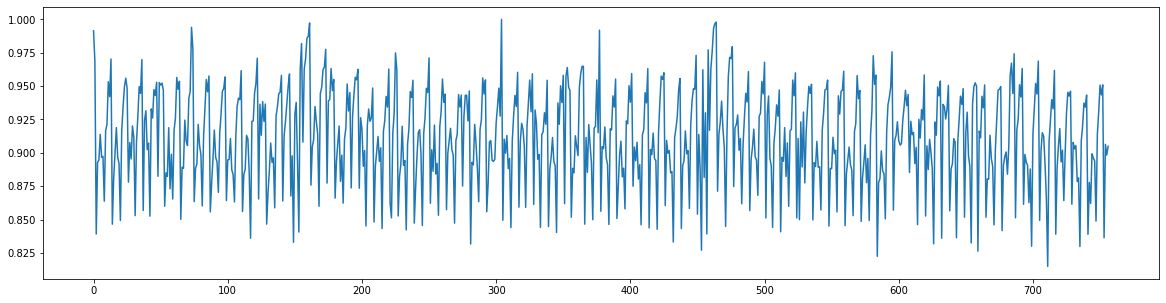

In [21]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,5))
plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
plt.show()
plt.figure(figsize=(20,5))
plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
plt.show()

In [22]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [23]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
    y_train = (df_train[y_out_columns].values - y_mean)/y_std
    y_val = (df_val[y_out_columns].values - y_mean)/y_std
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

In [24]:
lr = 0.001
model.compile(optimizer=Adam(lr=lr), metrics=['mse'], loss='mse')

In [25]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [26]:
epochs = 20
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], verbose=2)

Epoch 1/20

Epoch 00001: val_Sales_mse improved from inf to 0.10485, saving model to bestmodel.hdf5
3181/3181 - 11s - loss: 0.2738 - Sales_loss: 0.1254 - Customers_loss: 0.0896 - Sales_mse: 0.1254 - Customers_mse: 0.0896 - val_loss: 0.1962 - val_Sales_loss: 0.1048 - val_Customers_loss: 0.0625 - val_Sales_mse: 0.1048 - val_Customers_mse: 0.0625
Epoch 2/20

Epoch 00002: val_Sales_mse improved from 0.10485 to 0.09592, saving model to bestmodel.hdf5
3181/3181 - 11s - loss: 0.1450 - Sales_loss: 0.0737 - Customers_loss: 0.0462 - Sales_mse: 0.0737 - Customers_mse: 0.0462 - val_loss: 0.1658 - val_Sales_loss: 0.0959 - val_Customers_loss: 0.0475 - val_Sales_mse: 0.0959 - val_Customers_mse: 0.0475
Epoch 3/20

Epoch 00003: val_Sales_mse improved from 0.09592 to 0.09528, saving model to bestmodel.hdf5
3181/3181 - 11s - loss: 0.1230 - Sales_loss: 0.0640 - Customers_loss: 0.0386 - Sales_mse: 0.0640 - Customers_mse: 0.0386 - val_loss: 0.1672 - val_Sales_loss: 0.0953 - val_Customers_loss: 0.0532 - val_

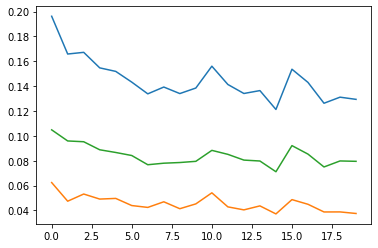

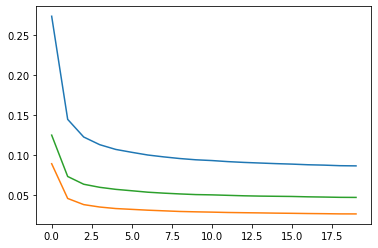

In [27]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_Customers_mse'])
plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['Customers_mse'])
plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [28]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 2s 2ms/step - loss: 0.1294 - Sales_loss: 0.0795 - Customers_loss: 0.0376 - Sales_mse: 0.0795 - Customers_mse: 0.0376


[0.12937156856060028,
 0.0795304998755455,
 0.03757552430033684,
 0.0795304998755455,
 0.03757552430033684]

In [29]:
model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 2s 2ms/step - loss: 0.1212 - Sales_loss: 0.0711 - Customers_loss: 0.0372 - Sales_mse: 0.0711 - Customers_mse: 0.0372


[0.12123582512140274,
 0.0711498111486435,
 0.037226542830467224,
 0.0711498111486435,
 0.037226542830467224]

In [30]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [31]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 3s 2ms/step


In [32]:
np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))

0.1187994164759673

In [33]:
y_pred_test[:10]

array([4409.71  , 6887.483 , 9291.851 , 7198.302 , 7054.4106, 5484.404 ,
       7422.7427, 7902.2266, 4599.8057, 5592.162 ], dtype=float32)

# Baseline

In [34]:
import pandas as pd
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [35]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [36]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [37]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [38]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales
543,702,0.0
676,878,0.0
840,1096,0.0
1399,702,0.0
1532,878,0.0


In [39]:
sample_csv['Sales'] = df_test['Sales']

In [40]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [41]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [42]:

sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

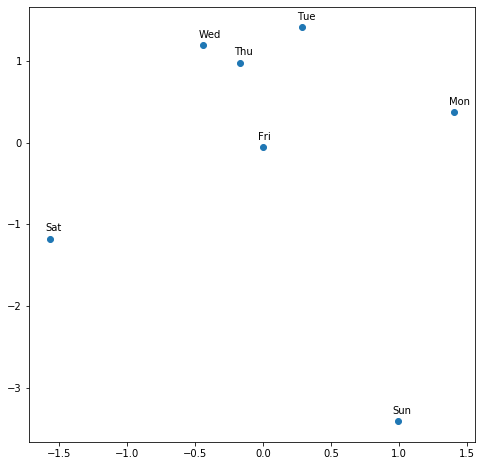

In [43]:
model.load_weights('bestmodel.hdf5')
#model.load_weights('initial_weights.hdf5')
day_of_week_embedding = model.get_layer('DayOfWeek_Embed').get_weights()[0]
Y = day_of_week_embedding
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [43]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [51]:
day_of_week_embedding.shape

(7, 2)

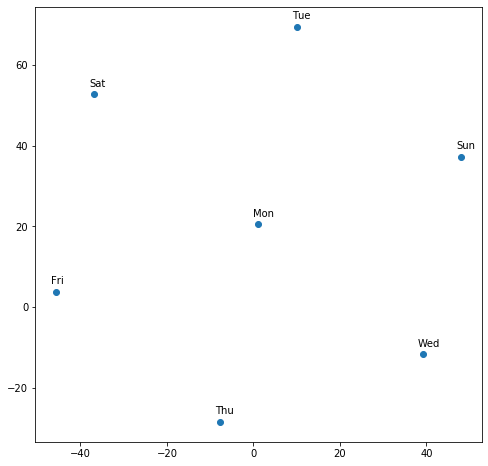

In [58]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

In [93]:
cat_vars

['Store',
 'DayOfWeek',
 'Year',
 'Month',
 'Day',
 'StateHoliday',
 'CompetitionMonthsOpen',
 'Promo2Weeks',
 'StoreType',
 'Assortment',
 'PromoInterval',
 'CompetitionOpenSinceYear',
 'Promo2SinceYear',
 'State',
 'Week',
 'Events',
 'Promo_fw',
 'Promo_bw',
 'StateHoliday_fw',
 'StateHoliday_bw',
 'SchoolHoliday_fw',
 'SchoolHoliday_bw']

## Store embeddings

In [94]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [95]:
submodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Store_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
DayOfWeek_input (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
Year_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
Month_input (InputLayer)        [(None, 1)]          0                                            
____________________________________________________________________________________________

In [52]:
submodel.save('embeddings_model.hdf5')